In [1]:
# load graph object from file
import pickle 
import os
import numpy as np 
G = pickle.load(open('G_politicans_final.pickle', 'rb'))
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns 
from collections import Counter
from collections import defaultdict
import math 
from wordcloud import WordCloud

In [52]:
# use louvain method to partition the graph
partition = nx.community.louvain_communities(G, seed = 1)
print(len(partition))

# calculate the modularity of the partition
modularity = nx.algorithms.community.modularity(G, partition )
print(modularity)

1186
0.7254021509165209


## TF-IDF SCORES and wordclouds for Parties ## 

In [65]:
# now we aggregate and clean the text, so we get 15 documents for each genre, with each document containing the text from the artists in that genre 
import os
import re
# Få den overordnede mappes sti
parent_directory = os.path.abspath(os.path.join(os.getcwd(), ".."))
artist_files_dir = os.path.join(parent_directory, "wiki_pages") 
output_dir = 'party_aggregated_text'  
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)
# Function to clean the text from the artist files
def clean_text(text):
    # Remove Wikipedia markup and unwanted sections
    cleaned_text = re.sub(r'\{\{.*?\}\}', '', text, flags=re.DOTALL)  # Remove infoboxes
    cleaned_text = re.sub(r'={2,}.*?={2,}', '', cleaned_text)  # Remove section headers
    cleaned_text = re.sub(r'\[\[.*?\]\]', '', cleaned_text)  # Remove internal links
    cleaned_text = re.sub(r'\[http[^\]]+\]', '', cleaned_text)  # Remove external links
    cleaned_text = re.sub(r'<ref>.*?</ref>', '', cleaned_text, flags=re.DOTALL)  # Remove <ref> tags
    cleaned_text = re.sub(r'\{.*?\}', '', cleaned_text, flags=re.DOTALL)  # Remove curly braces content
    cleaned_text = re.sub(r'<.*? colspan\s*=\s*".*?".*?>', '', cleaned_text)  # Remove HTML tags with colspan attribute
    cleaned_text = re.sub(r'<.*? rowspans*=".*?".*?>', '', cleaned_text)  # Remove HTML tags with rowspan attribute
    cleaned_text = re.sub(r'<.*?>', '', cleaned_text)  # Remove all HTML tags
    cleaned_text = re.sub(r'<table.*?>.*?</table>', '', cleaned_text, flags=re.DOTALL)  # Remove whole tables
    cleaned_text = re.sub(r'\|}', '', cleaned_text)  # Remove table closing tags
    cleaned_text = re.sub(r'<small>.*?</small>', '', cleaned_text, flags=re.DOTALL)  # Remove <small> tags
    cleaned_text = re.sub(r'^\s*$', '', cleaned_text, flags=re.MULTILINE)  # Remove empty lines
    cleaned_text = cleaned_text.replace("—", "")  # Remove dash characters
    cleaned_text = cleaned_text.strip()  # Remove leading/trailing whitespace
    return cleaned_text
# Dictionary to hold aggregated text for each genre
aggregated_content = {}


# Iterate through each genre in top_15_genres
for _, party in enumerate(np.array(list(set(nx.get_node_attributes(G, 'party').values())))):
    aggregated_content[party] = []
    # Get the list of artists for the current genre
    #artists = partition_genre[party]
    partymembers = [node for node, data in G.nodes(data=True) if data.get('party') == party]
   

    # Read each artist's text file
    for partymember in partymembers:
        member_file_path = os.path.join(artist_files_dir, f'{partymember}.json')  # Assuming file names match artist names
        print(member_file_path)
        if os.path.exists(member_file_path):
            with open(member_file_path, 'r', encoding='utf-8') as file:
                member_text = file.read()
                cleaned_member_text = clean_text(member_text)
                aggregated_content[party].append(cleaned_member_text)

    # Write the aggregated content to a separate file for the current genre
    output_file_path = os.path.join(output_dir, f'{party}.txt')  # Output file for the genre
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(f'Party: {party}\n')
        output_file.write('\n'.join(aggregated_content[party]) + '\n')



c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Aaron_M._Dana.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Adam_Hattersley.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Alicia_Limtiaco.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Althea_Garrison.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Al_Gross_(politician).json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Angus_King.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Anthony_Napolitano.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Austin_Quinn-Davidson.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Avel_Gordly.json
c:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\wiki_pages\Barbara_Murphy_(politician).json
c:\U

In [68]:
# now we create the term frequency for each words in each of the aggregated genre files.
text_folder = r"party_aggregated_text"
output_folder = r"party_aggregated_text_TF"

os.makedirs(output_folder, exist_ok=True)


def extract_words(text):
    
    text = re.sub(r'[^\w\s]', '', text)  
    words = text.lower().split()  
    return words

for filename in os.listdir(text_folder):
    if filename.endswith('.txt'):
        try:
           
            with open(os.path.join(text_folder, filename), 'r', encoding='utf-8') as f:
                content = f.read()

                
                words = extract_words(content)

                
                word_counts = Counter(words)

               
                output_file = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_tf.txt")
                with open(output_file, 'w', encoding='utf-8') as output:
                    for word, count in word_counts.items():
                        output.write(f"{word} {count}\n")
        
        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")


In [74]:
# time to compute the IDF scores for the genre words

text_folder = r"party_aggregated_text_TF"

def extract_words(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove specialtegn
    words = text.lower().split()  # make everything lower case 
    return words

doc_count = 0
term_doc_count = defaultdict(int)

for filename in os.listdir(text_folder):
    if filename.endswith('.txt'):
        try:
            # read content of file 
            with open(os.path.join(text_folder, filename), 'r', encoding='utf-8') as f:
                content = f.read()
                doc_count += 1  # opdate number of dokuments

                # get the unique words 
                unique_words = set(extract_words(content))

                # opdate document count 
                for word in unique_words:
                    term_doc_count[word] += 1

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

#calculate idf for each word/term 
idf_scores = {term: math.log(doc_count / count) for term, count in term_doc_count.items()}

# save the idf score in the same folder as tf
output_idf_file = os.path.join(text_folder, "idf_scores.txt")
with open(output_idf_file, 'w', encoding='utf-8') as output:
    for term, score in idf_scores.items():
        output.write(f"{term} {score}\n")



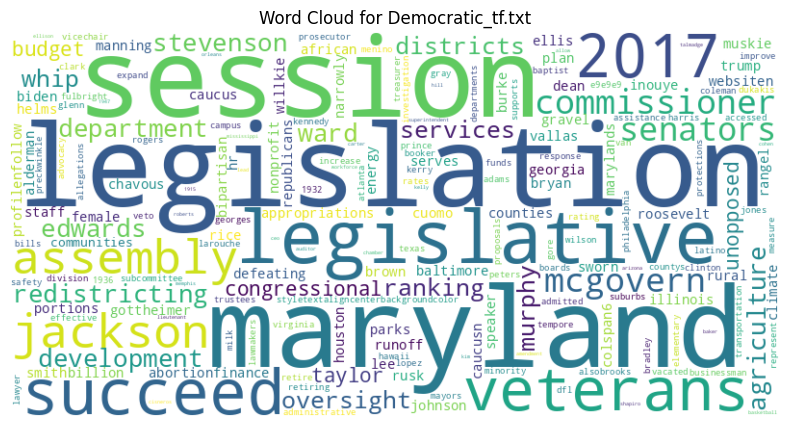

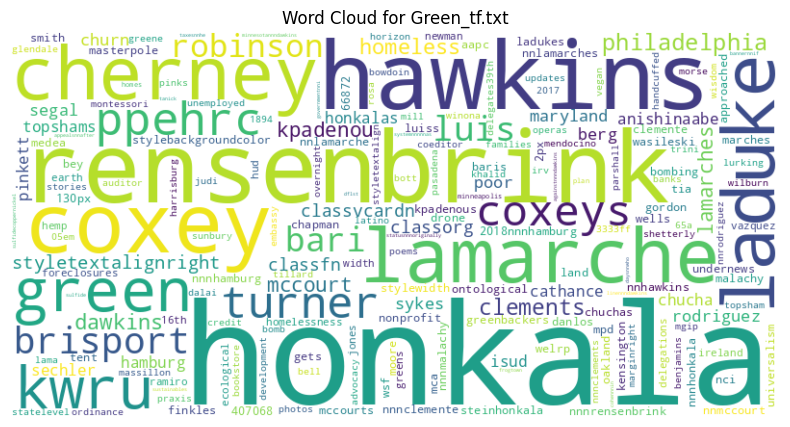

An error occurred while processing idf_scores.txt: invalid literal for int() with base 10: '1.791759469228055'


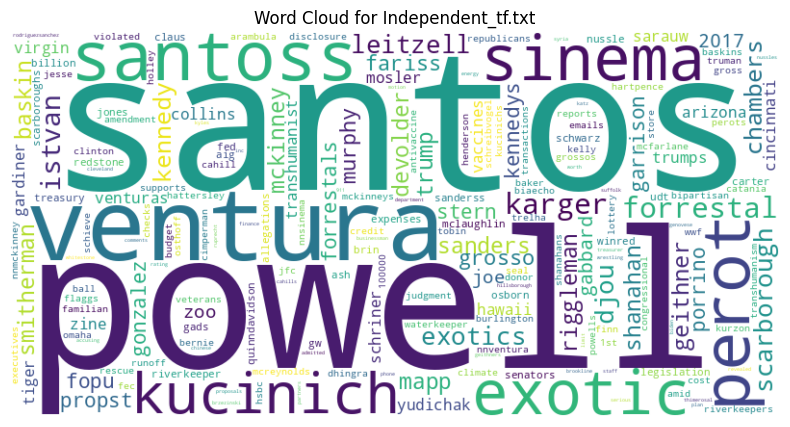

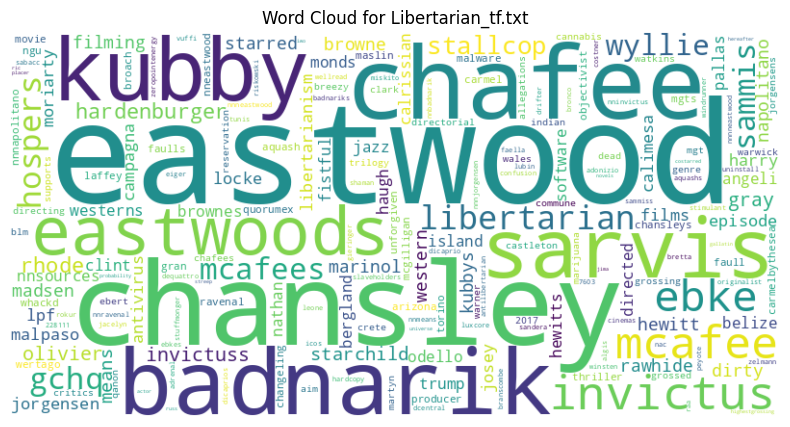

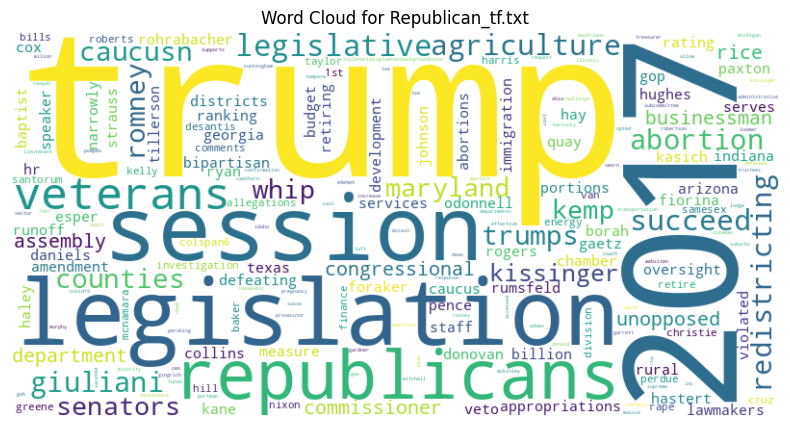

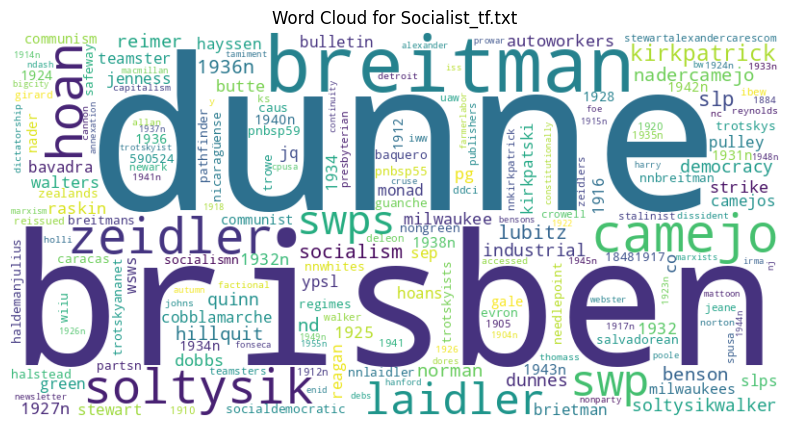

Word clouds generated and displayed.


In [3]:
# Time to visualize the word clouds for the genres based on the TF-IDF scores. 
tf_folder = r"party_aggregated_text_TF"
#idf_file_path = r"idf_scores.txt"
idf_file_path = r"C:\Users\jbirk\OneDrive\Skrivebord\Social graphs and interactions\SocialGraphs_USAPoliticians\party_aggregated_text_TF\idf_scores.txt"

idf_scores = {}
with open(idf_file_path, 'r', encoding='utf-8') as idf_file:
    for line in idf_file:
        word, score = line.strip().split()
        idf_scores[word] = float(score)


for filename in os.listdir(tf_folder):
    if filename.endswith('.txt'): 
        try:
            
            tf_scores = {}
            with open(os.path.join(tf_folder, filename), 'r', encoding='utf-8') as tf_file:
                for line in tf_file:
                    word, count = line.strip().split()
                    tf_scores[word] = int(count)

            # compute the TF-IDF score 
            tfidf_scores = {word: tf * idf_scores.get(word, 0) for word, tf in tf_scores.items()}

            # create wordcloud
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

            # plot wordcliud
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')  
            plt.title(f'Word Cloud for {filename}')
            plt.show()  

            
            wordcloud_file_path = os.path.join(tf_folder, f'{os.path.splitext(filename)[0]}_wordcloud.png')
            wordcloud.to_file(wordcloud_file_path)

        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

print("Word clouds generated and displayed.")

## Confusion matrix ## 





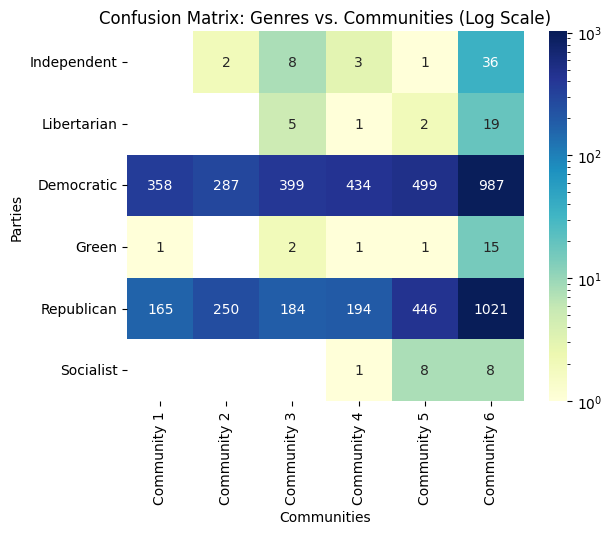

In [53]:
parties = set(nx.get_node_attributes(G, 'party').values())
parties_array = np.array(list(parties))

# Identify the 8 most common communities
community_sizes = [len(community) for community in partition]
most_common_communities_indices = np.argsort(community_sizes)[-6:]
most_common_communities = [partition[i] for i in most_common_communities_indices]

# Create the confusion matrix D
D = np.zeros((6, 6), dtype=int)

# Populate the matrix D
for i, party in enumerate(parties_array):
    for j, community in enumerate(most_common_communities):
        # Tæl antallet af noder i community, der har det givne party
        count = sum(1 for node in community if G.nodes[node].get('party') == party)
        D[i, j] = count

# Define the labels for the genres and communities
genre_labels = parties_array
community_labels = [f'Community {i+1}' for i in range(6)]

# Create the heatmap with a logarithmic scale
#plt.figure(figsize=(10, 8))
sns.heatmap(D, annot=True, fmt='d', cmap='YlGnBu', xticklabels=community_labels, yticklabels=genre_labels,  norm=LogNorm())
plt.xlabel('Communities')
plt.ylabel('Parties')
plt.title('Confusion Matrix: Genres vs. Communities (Log Scale)')
plt.show()